In [1]:
# %pip install geopandas pandas shapely scipy seaborn

In [2]:
import pandas as pd
import numpy as np

from io import StringIO

from shapely.geometry import Point
import geopandas
from geopandas import datasets, GeoDataFrame, read_file

from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 999

## Load Data

In [3]:
service_requests_311 = pd.read_csv(
    "../data/raw/311_City_Service_Requests_in_2022.csv.gz",
    parse_dates=["RESOLUTIONDATE", "ADDDATE", "SERVICEDUEDATE", "SERVICEORDERDATE"],
)
service_requests_311.columns = [c.lower() for c in service_requests_311.columns]
service_requests_311["days_to_resolution"] = (
    service_requests_311.resolutiondate - service_requests_311.adddate
) / np.timedelta64(1, "D")
service_requests_311["resolved"] = service_requests_311.resolutiondate.notnull()
service_requests_311.shape

/var/folders/tx/fmb4v8gn6mj5c6shgzfqgkjm0000gq/T/ipykernel_73427/138528747.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  service_requests_311 = pd.read_csv(


(385688, 38)

In [4]:
cm_data_smd = pd.read_csv("../data/clean/cm_anc_data.csv", index_col="smd_22")
cm_data_smd

,ward,cm,anc_22,smd_22.1,cm_residence_smd_22,cm_adjacent_smd_22,cm_res_or_adj_smd_22
smd_22,,,,,,,
1A09,1,Nadeau,1A,1A09,1,0,1
1A07,1,Nadeau,1A,1A07,0,1,1
1A08,1,Nadeau,1A,1A08,0,1,1
1A10,1,Nadeau,1A,1A10,0,1,1
2F01,2,Pinto,2F,2F01,1,0,1
2F02,2,Pinto,2F,2F02,0,1,1
2F04,2,Pinto,2F,2F04,0,1,1
2B04,2,Pinto,2F,2B04,0,1,1
1B12,2,Pinto,2F,1B12,0,1,1


In [5]:
# create a similar DF with just the ANC so the join pattern is the same
cm_data_anc = (
    cm_data_smd[cm_data_smd.cm_residence_smd_22 == 1]
    .copy()
    .set_index("anc_22")
    .drop(["smd_22.1", "cm_adjacent_smd_22", "cm_res_or_adj_smd_22"], axis=1)
    .rename({"cm_residence_smd_22": "cm_residence_anc_22"}, axis=1)
)

In [6]:
cm_data_anc

,ward,cm,cm_residence_anc_22
anc_22,,,
1A,1,Nadeau,1
2F,2,Pinto,1
3F,3,Cheh,1
4B,4,George,1
5E,5,McDuffie,1
6C,6,Allen,1
7B,7,Gray,1
8E,8,White,1


## Geospatial joins of 311 request data to ANC districts

In [7]:
service_requests_311_geo = geopandas.GeoDataFrame(
    service_requests_311,
    geometry=geopandas.points_from_xy(
        service_requests_311.longitude, service_requests_311.latitude
    ),
)

In [8]:
smd_df = read_file("../data/clean/Single_Member_District_from_2013.zip")

In [9]:
smd_df.head()

,OBJECTID,SMD_ID,ANC_ID,WEB_URL,NAME,CHAIR,REP_NAME,LAST_NAME,FIRST_NAME,ADDRESS,EMAIL,MIDDLE_NAM,PHONE,ZIPCODE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1921,6A08,6A,https://anc6a.org/,SMD 6A08,NaN,Brian Alcorn,Alcorn,Brian,"31 15th Street, NE",6A08@anc.dc.gov,NaN,202-548-8133,20002.0,{50EE2D05-BD0F-47E6-8A9D-CE546116882C},JLAY,2022-09-08,JLAY,2022-09-08,0,0,"POLYGON ((-76.97726 38.89612, -76.97726 38.896..."
1,1922,6D06,6D,https://www.anc6d.org/,SMD 6D06,NaN,Rhonda Natalie Hamilton,Hamilton,Rhonda,"44 O Street, SW #12",6D06@anc.dc.gov,Natalie,202-316-5827,20024.0,{1F9B223D-AF77-4606-B6E4-2E06C29A4E7A},JLAY,2022-09-08,JLAY,2022-09-08,0,0,"POLYGON ((-77.00910 38.87648, -77.00910 38.875..."
2,1923,6D04,6D,https://www.anc6d.org/,SMD 6D04,NaN,Andy Litsky,Litsky,Andy,"423 N Street, SW",6D04@anc.dc.gov,NaN,202-554-8070,20024.0,{A9BBB28A-470F-4E6A-BEF9-E6B5526B19D9},JLAY,2022-09-08,JLAY,2022-09-08,0,0,"POLYGON ((-77.01989 38.87647, -77.01944 38.876..."
3,1924,6D05,6D,https://www.anc6d.org/,SMD 6D05,NaN,Fredrica Kramer,Kramer,Fredrica,"387 O SW Street, SW",6D05@anc.dc.gov,NaN,202-352-0129,20024.0,{0A7C77CE-34E1-4E68-9ED6-AAEBD607A68A},JLAY,2022-09-08,JLAY,2022-09-08,0,0,"POLYGON ((-77.01738 38.87929, -77.01670 38.879..."
4,1925,7C01,7C,http://anc7c.org/#,SMD 7C01,NaN,Patricia Malloy,Malloy,Patricia,"501 50th Place, NE",7C01@anc.dc.gov,<Null>,202-549-3312,20019.0,{0C0B0EBF-E64E-4F3F-A896-F802AFF21D72},JLAY,2022-09-08,JLAY,2022-09-08,0,0,"POLYGON ((-76.92752 38.90184, -76.92702 38.901..."


<Axes: >

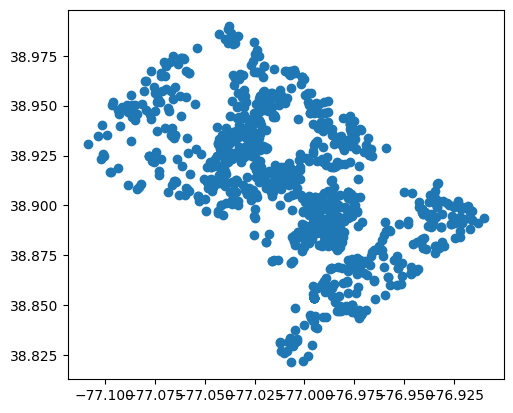

In [10]:
# sanity check
service_requests_311_geo.head(1000).plot()

<Axes: >

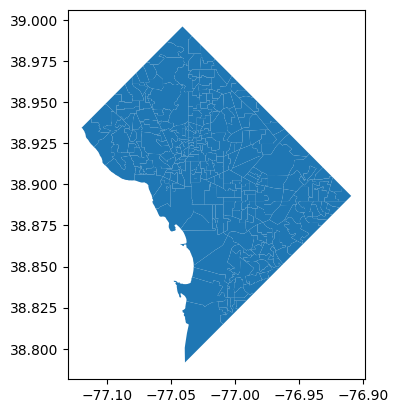

In [11]:
# sanity check
smd_df.plot()

In [12]:
# force CRS to match
service_requests_311_geo.crs = smd_df.crs

In [13]:
service_requests_311_geo_join = service_requests_311_geo.sjoin(smd_df, how="inner")

In [14]:
service_requests_311_geo_join.head().T

,0,57,81,146,442
x,-77.028751,-77.027376,-77.026931,-77.02949,-77.029375
y,38.935123,38.934201,38.931889,38.934972,38.934307
objectid,10050224,10050809,10050833,10050898,10051226
servicecode,S0441,S0031,S0031,S0031,S0346
servicecodedescription,Trash Collection - Missed,Bulk Collection,Bulk Collection,Bulk Collection,Sanitation Enforcement
servicetypecodedescription,SWMA- Solid Waste Management Admistration,SWMA- Solid Waste Management Admistration,SWMA- Solid Waste Management Admistration,SWMA- Solid Waste Management Admistration,SWMA- Solid Waste Management Admistration
organizationacronym,DPW,DPW,DPW,DPW,DPW
servicecallcount,1,1,1,1,1
adddate,2022-01-01 05:20:59+00:00,2022-01-01 16:37:44+00:00,2022-01-01 17:09:52+00:00,2022-01-01 20:41:05+00:00,2022-01-02 18:05:13+00:00
resolutiondate,2022-01-12 21:45:32+00:00,2022-01-07 15:45:47+00:00,2022-01-07 21:43:12+00:00,2022-01-07 21:43:26+00:00,2022-01-12 19:25:44+00:00


In [15]:
# This could be DRYer
all_data = service_requests_311_geo_join.join(
    cm_data_smd, on="SMD_ID", how="left", rsuffix="_cm"
)
all_data.rename(
    {"smd_22.1": "smd_22"}, axis=1, inplace=True
)  # need to clean up join vs. merge but this is fine for now

In [16]:
all_data = all_data.join(
    cm_data_anc, on="ANC_ID", how="left", rsuffix="_cm"
)
all_data.columns = [c.lower() for c in all_data.columns]

In [17]:
# this DF now has the kitchen sink
all_data.columns

Index(['x', 'y', 'objectid', 'servicecode', 'servicecodedescription',
       'servicetypecodedescription', 'organizationacronym', 'servicecallcount',
       'adddate', 'resolutiondate', 'serviceduedate', 'serviceorderdate',
       'inspectionflag', 'inspectiondate', 'inspectorname',
       'serviceorderstatus', 'status_code', 'servicerequestid', 'priority',
       'streetaddress', 'xcoord', 'ycoord', 'latitude', 'longitude', 'city',
       'state', 'zipcode', 'maraddressrepositoryid', 'ward', 'details',
       'gis_id', 'globalid', 'creator', 'created', 'editor', 'edited',
       'days_to_resolution', 'resolved', 'geometry', 'index_right', 'objectid',
       'smd_id', 'anc_id', 'web_url', 'name', 'chair', 'rep_name', 'last_name',
       'first_name', 'address', 'email', 'middle_nam', 'phone', 'zipcode',
       'globalid', 'creator', 'created', 'editor', 'edited', 'shapearea',
       'shapelen', 'ward_cm', 'cm', 'anc_22', 'smd_22', 'cm_residence_smd_22',
       'cm_adjacent_smd_22', 'cm

In [18]:
# A sane subset of columns
columns = [
    "servicecodedescription",
    "days_to_resolution",
    "ward",
    "ward_cm",
    "cm",
    "anc_22",
    "smd_22",
    "cm_residence_smd_22",
    "cm_residence_anc_22",
    "cm_adjacent_smd_22",
    "cm_res_or_adj_smd_22",
]

In [19]:
all_data[columns]

,servicecodedescription,days_to_resolution,ward,ward_cm,ward_cm,cm,anc_22,smd_22,cm_residence_smd_22,cm_residence_anc_22,cm_adjacent_smd_22,cm_res_or_adj_smd_22
0,Trash Collection - Missed,11.683715,1,1.0,1.0,Nadeau,1A,1A07,0.0,1.0,1.0,1.0
57,Bulk Collection,5.963924,1,1.0,1.0,Nadeau,1A,1A07,0.0,1.0,1.0,1.0
81,Bulk Collection,6.189815,1,1.0,1.0,Nadeau,1A,1A07,0.0,1.0,1.0,1.0
146,Bulk Collection,6.043299,1,1.0,1.0,Nadeau,1A,1A07,0.0,1.0,1.0,1.0
442,Sanitation Enforcement,10.055914,1,1.0,1.0,Nadeau,1A,1A07,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
242444,Traffic Safety Investigation,35.967384,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261951,Scheduled Yard Waste,7.946296,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270918,Scheduled Yard Waste,6.866956,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274838,Sidewalk Repair,1.775069,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
all_data.groupby("ward")[
    [
        "cm_residence_anc_22",
        "cm_residence_smd_22",
        "cm_adjacent_smd_22",
        "cm_res_or_adj_smd_22",
    ]
].sum()

,cm_residence_anc_22,cm_residence_smd_22,cm_adjacent_smd_22,cm_res_or_adj_smd_22
ward,,,,
1,17613.0,1695.0,9185.0,10880.0
2,7159.0,1642.0,2658.0,4300.0
3,4202.0,782.0,792.0,1574.0
4,15895.0,1719.0,5578.0,7297.0
5,20620.0,1674.0,1762.0,3436.0
6,13438.0,2364.0,11010.0,13374.0
7,9776.0,848.0,2453.0,3301.0
8,5599.0,935.0,11967.0,12902.0
Null,356.0,104.0,313.0,417.0


In [21]:
all_data["cm_residence_anc_22"] = all_data.cm_residence_anc_22.fillna(0).apply(bool)
all_data["cm_residence_smd_22"] = all_data.cm_residence_smd_22.fillna(0).apply(bool)
all_data["cm_adjacent_smd_22"] = all_data.cm_adjacent_smd_22.fillna(0).apply(bool)
all_data["cm_res_or_adj_smd_22"] = all_data.cm_res_or_adj_smd_22.fillna(0).apply(bool)

In [22]:
# Kind of eyeballed these for relevance and sample size, need to come back and be more rigorous
relevant_categories = (
    "Alley",
    "Bicycle",
    "DCRA",
    "DC Facilities",
    "DOB",
    "Graffiti",
    "Grass",
    "Illegal Dumping",
    "Leaf",
    "Public Space" "Roadway",
    "Rodent" "Sidewalk",
    "Traffic Safety",
    "Tree",
)

In [23]:
all_data_relevant = all_data[
    (all_data.servicecodedescription.str.startswith(relevant_categories)) & (all_data.ward != "Null")
]

In [24]:
pd.DataFrame(
    all_data_relevant.groupby(["servicecodedescription", "ward", "cm_residence_anc_22"])
    .days_to_resolution.agg(["mean", "median", "count"])
    .round(1)
)

mean  \
servicecodedescription                             ward cm_residence_anc_22          
Alley Cleaning                                     1    False                 36.9   
                                                        True                  30.6   
                                                   2    False                 57.1   
                                                        True                  56.1   
                                                   3    False                 34.3   
                                                        True                  25.0   
                                                   4    False                 39.2   
                                                        True                  36.5   
                                                   5    False                 38.1   
                                                        True                  35.5   
                                                   6    False                 41.3   
                                                        True                  40.6   
                                                   7    False                 26.5   
                                                        True                  27.2   
                                                   8    False                 27.5   
                                                        True                  30.5   
Alley Repair                                       1    False                 59.2   
                                                        True                  29.9   
                                                   2    False                 72.1   
                                                        True                  75.7   
                                                   3    False                 30.2   
                                                        True                   7.4   
                                                   4    False                 59.3   
                                                        True                  92.1   
                                                   5    False                 72.1   
                                                        True                  87.6   
                                                   6    False                 34.4   
                                                        True                  67.9   
                                                   7    False                 60.7   
                                                        True                  52.7   
                                                   8    False                 21.7   
                                                        True                   NaN   
Bicycle Services                                   1    False                 31.7   
                                                        True                  30.4   
                                                   2    False                 44.2   
                                                        True                  25.8   
                                                   3    False                 45.2   
                                                        True                  28.3   
                                                   4    False                 49.6   
                                                        True                  28.8   
                                                   5    False                 40.3   
                                                        True                  41.9   
                                                   6    False                 38.8   
                                                        True                  56.3   
                                                   7    False                 47.6   
                                    

## T-tests

In [25]:
all_data_relevant.ward.value_counts()

ward
5    8941
1    8119
4    7711
7    7650
2    6858
6    6031
3    4647
8    4325
Name: count, dtype: int64

In [26]:
result = []
for w in all_data_relevant.ward.dropna().sort_values().unique():
    for s in all_data_relevant.servicecodedescription.sort_values().unique():
        trues = all_data_relevant[
            (all_data_relevant.ward == w)
            & (all_data_relevant.servicecodedescription == s)
            & (all_data_relevant.cm_residence_anc_22 == True)
            & all_data_relevant.days_to_resolution.notnull()
        ].days_to_resolution
        falses = all_data_relevant[
            (all_data_relevant.ward == w)
            & (all_data_relevant.servicecodedescription == s)
            & (all_data_relevant.cm_residence_anc_22 == False)
            & all_data_relevant.days_to_resolution.notnull()
        ].days_to_resolution
        t_score = ttest_ind(trues, falses)
        result.append(
            {
                "ward": w,
                "servicecodedescription": s,
                "pvalue": round(t_score.pvalue, 5),
                "cm_true_avg": round(trues.mean(), 1),
                "cm_false_avg": round(falses.mean(), 1),
                "count": trues.shape[0] + falses.shape[0]
            }
        )

In [27]:
result = pd.DataFrame(result)

In [28]:
result["cm_faster"] = result.cm_true_avg < result.cm_false_avg

In [29]:
result["statsig"] = result.pvalue < .05

In [30]:
result["cm_faster_statsig"] = result.apply(lambda x: x["cm_faster"] * x["statsig"] == 1, axis=1)

In [31]:
result

,ward,servicecodedescription,pvalue,cm_true_avg,cm_false_avg,count,cm_faster,statsig,cm_faster_statsig
0,1,Alley Cleaning,0.00026,30.6,36.9,512,True,True,True
1,1,Alley Repair,0.23387,29.9,59.2,24,True,False,False
2,1,Bicycle Services,0.83916,30.4,31.7,98,True,False,False
3,1,DC Facilities Landscaping and Grounds Maintena...,0.64827,28.8,35.6,38,True,False,False
4,1,DCRA - Illegal Construction,0.08496,27.8,34.8,121,True,False,False
5,1,DCRA - Vacant Private Property Inspection,0.17686,28.2,23.5,682,False,False,False
6,1,DOB - Illegal Construction,0.93215,40.3,39.7,31,False,False,False
7,1,DOB - Vacant Private Property Inspection,0.55648,12.1,13.1,181,True,False,False
8,1,Graffiti Removal,0.27700,8.1,8.9,1486,True,False,False
9,1,Grass and Weeds Mowing,0.16309,9.4,7.5,129,False,False,False


In [32]:
# this doesn't work
"""
pd.DataFrame(
    all_data_relevant.groupby(
        ["servicecodedescription", "ward", "cm_res_or_adj_22"]
    )
    .days_to_resolution.median()
    .round(1).reset_index()
).pivot(
    index="servicecodedescription",
    columns="ward",
    values=["cm_res_or_adj_22", "days_to_resolution"],
)
"""

'\npd.DataFrame(\n    all_data_relevant.groupby(\n        ["servicecodedescription", "ward", "cm_res_or_adj_22"]\n    )\n    .days_to_resolution.median()\n    .round(1).reset_index()\n).pivot(\n    index="servicecodedescription",\n    columns="ward",\n    values=["cm_res_or_adj_22", "days_to_resolution"],\n)\n'

In [33]:
"""all_data_relevant.pivot(
    index="servicecodedescription",
    columns="ward",
    values=["cm_res_or_adj_22", "days_to_resolution"],
)"""

'all_data_relevant.pivot(\n    index="servicecodedescription",\n    columns="ward",\n    values=["cm_res_or_adj_22", "days_to_resolution"],\n)'

In [34]:
""" Commenting out because this takes a long time to run
g = sns.displot(
    data=all_data_relevant,
    row="servicecodedescription",
    col="ward",
    x="days_to_resolution",
    hue="cm_res_or_adj_22",
    kind="kde",
    common_norm=False,
    palette="tab10",
)


def specs(x, **kwargs):
    plt.axvline(x.mean(), c="k", ls="-", lw=2.5)
    plt.axvline(x.median(), c="orange", ls="--", lw=2.5)


g.map(specs, "days_to_resolution")
"""

' Commenting out because this takes a long time to run\ng = sns.displot(\n    data=all_data_relevant,\n    row="servicecodedescription",\n    col="ward",\n    x="days_to_resolution",\n    hue="cm_res_or_adj_22",\n    kind="kde",\n    common_norm=False,\n    palette="tab10",\n)\n\n\ndef specs(x, **kwargs):\n    plt.axvline(x.mean(), c="k", ls="-", lw=2.5)\n    plt.axvline(x.median(), c="orange", ls="--", lw=2.5)\n\n\ng.map(specs, "days_to_resolution")\n'

In [35]:
g = sns.FacetGrid(
    all_data_relevant, row="servicecodedescription", hue="cm_res_or_adj_22"
)
g.map(sns.histplot, "days_to_resolution", stat="density", common_norm=False, bins=50)

KeyError: 'cm_res_or_adj_22'

### T Tests

In [ ]:
pd.DataFrame(
    service_requests_311_w1_relevant.groupby(["servicecodedescription", "in_park_view"])
    .days_to_resolution.agg(["mean", "median", "count"])
    .round(1)
)

In [ ]:
pd.DataFrame(
    service_requests_311.groupby(["servicecodedescription", "ward"])
    .days_to_resolution.agg(["mean", "median", "count"])
    .round(1)
)

In [ ]:
service_requests_311.servicecodedescription.value_counts()

In [ ]:
pd.DataFrame(
    all_data_relevant.groupby(["servicecodedescription"])
    .days_to_resolution.agg(["mean", "median", "count"])
    .round(1)
)

In [ ]:
service_requests_311[
    (service_requests_311.servicecodedescription == "Sidewalk Repair")
].resolutiondate.isnull().value_counts()

In [ ]:
# percent resolved by whether in or adjacent CM's ANC SMD
pd.DataFrame(
    all_data_relevant.groupby(["servicecodedescription", "ward", "cm_res_or_adj_22"])
    .resolved.agg(["mean", "count"])
    .round(3)
)

In [42]:
all_data.columns

Index(['x', 'y', 'objectid', 'servicecode', 'servicecodedescription',
       'servicetypecodedescription', 'organizationacronym', 'servicecallcount',
       'adddate', 'resolutiondate', 'serviceduedate', 'serviceorderdate',
       'inspectionflag', 'inspectiondate', 'inspectorname',
       'serviceorderstatus', 'status_code', 'servicerequestid', 'priority',
       'streetaddress', 'xcoord', 'ycoord', 'latitude', 'longitude', 'city',
       'state', 'zipcode', 'maraddressrepositoryid', 'ward', 'details',
       'gis_id', 'globalid', 'creator', 'created', 'editor', 'edited',
       'days_to_resolution', 'resolved', 'geometry', 'index_right', 'objectid',
       'smd_id', 'anc_id', 'web_url', 'name', 'chair', 'rep_name', 'last_name',
       'first_name', 'address', 'email', 'middle_nam', 'phone', 'zipcode',
       'globalid', 'creator', 'created', 'editor', 'edited', 'shapearea',
       'shapelen', 'ward_cm', 'cm', 'anc_22', 'smd_22', 'cm_residence_smd_22',
       'cm_adjacent_smd_22', 'cm

In [61]:
all_data_relevant["resolutiondate_date"] = all_data_relevant.resolutiondate.dt.date

/Users/tterry/projects/dc-public-data/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [62]:
all_data_relevant.groupby(
    [
        "servicecodedescription",
        "resolutiondate_date",
    ]
).size().groupby("servicecodedescription", group_keys=False).apply(
    lambda x: x.sort_values(ascending=False).head(3)
)

servicecodedescription                                  resolutiondate_date
Alley Cleaning                                          2022-05-01              152
                                                        2022-09-22              145
                                                        2022-09-13              106
Alley Repair                                            2022-08-25                9
                                                        2022-11-04                8
                                                        2022-09-29                8
Bicycle Services                                        2022-10-05               70
                                                        2022-10-07               55
                                                        2022-05-12               39
DC Facilities Landscaping and Grounds Maintenance(DGS)  2022-09-13              114
                                                        2022-06-14               49
